# <p style="text-align: center;"> Creating and Refining Dictionary with Word Embedding Models

<p style="text-align: left;">Charter School Identities Project<br/><br/>Creator: Jaren Haber, PhD Candidate<br/>Institution: Department of Sociology, University of California, Berkeley<br/>Date created: July 20, 2018<br/>Date last modified: October 29, 2019
    
Description: This notebook views the word embedding model generated from charter school websites and uses it to expand and refine a dictionary for the educational ideology of inquiry-based learning.

## Initialize Python

In [1]:
# Import key packages
import gensim # for word embedding models
import _pickle as cPickle # Optimized version of pickle
import gc # For managing garbage collector
from collections import Counter # For counting terms across the corpus

# Import functions from other scripts
import sys; sys.path.insert(0, "../data_management/tools/") # To load functions from files in data_management/tools
from textlist_file import write_list, load_list # For saving and loading text lists to/from file
from df_tools import check_df, convert_df, load_filtered_df, replace_df_nulls # For displaying basic DF info, storing DFs for memory efficiency, and loading a filtered DF
from quickpickle import quickpickle_dump, quickpickle_load # For quickly loading & saving pickle files in Python
#import count_dict # For counting word frequencies in corpus (to assess candidate words)
#from count_dict import load_dict, Page, dict_precalc, dict_count, create_cols, count_words, collect_counts, count_master

In [2]:
# FOR CLEANING, TOKENIZING, AND STEMMING THE TEXT
from nltk import word_tokenize, sent_tokenize # widely used text tokenizer
from nltk.stem.porter import PorterStemmer # approximate but effective (and common) method of normalizing words: stems words by implementing a hierarchy of linguistic rules that transform or cut off word endings

In [3]:
# FOR VISUALIZATIONS
import matplotlib
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE # For visualizing word embeddings
from scipy.spatial import distance # To use cosine distances for tSNE metric

# Visualization parameters
%pylab inline 
%matplotlib inline
#matplotlib.style.use('white')

import seaborn as sns # To make matplotlib prettier
sns.set(style='white')
#sns.despine()

Populating the interactive namespace from numpy and matplotlib


In [4]:
# Define file paths
home = '/home/jovyan/work/'
wem_path = home + 'wem4themes/data/wem_model_300dims.bin' # path to WEM model
charter_path = home + 'misc_data/charters_2015.pkl' # path to charter school data file
dict_path = home + 'text_analysis/dictionary_methods/dicts/' # path to dictionary files (may not be used here)

In [5]:
# For counting term frequencies, load text corpus:
df = load_filtered_df(charter_path, ["WEBTEXT", "NCESSCH"])
df['WEBTEXT']=df['WEBTEXT'].fillna('') # turn nan to empty iterable for future convenience

# rows and cols:  (10965, 2)
# duplicates by NCESSCH: 0

Columns and # missing cases (if any): 
NCESSCH
WEBTEXT


## Define helper functions

In [6]:
def dict_cohere(thisdict, wem_model):
    '''Computes the average cosine similarity score of terms within one dictionary with all other terms in that same dictionary,
    effectively measuring the coherence of the dictionary.
    ...question for development: does it make sense to compare the average cosine similarity score between all terms 
    in thisdict and the average cosine similarity among the total model vocabulary? (Could that be, by definition, 0?)
    
    NOTE: For an unknown reason, calling this function deletes terms from thisdict.
    
    Inputs: List of key terms, word2vec model.
    Output: Average cosine similarity score of each word with all other words in the list of key terms.'''
    
    # Initialize average distance variables:
    word_avg_dist = 0
    word_avg_dists = 0
    dict_avg_sim = 0
    all_avg_dists = 0
    model_avg_dists = 0
    
    # Compute average cosine similarity score of each word with other dict words:
    for word in thisdict:
        word_avg_dist = (wem_model.distances(word, other_words=thisdict).sum())/len(thisdict) # Total diffs of word with all other words, take average
        word_avg_dists += word_avg_dist # Add up each average distance, incrementally
    dict_avg_sim = 1 - word_avg_dists/len(thisdict) # Find average cosine similarity score by subtracting avg. distance from 1

    # For comparison, compute average cosine similarity score of each word with ALL other words in the model vocabulary:
    #for word in thisdict:
    #    all_avg_dist = (wem_model.distances(word).sum())/len(model.vocab) # Default is to compare each word with all words
    #    all_avg_dists += all_avg_dist
    #model_avg_dist = 1 - all_avg_dists/len(model.vocab) # Find average cosine similarity score by subtracting avg. distance from 1

    #print("Average cosine similarities by word for this dictionary:       \t" + str(dict_avg_dist))
    #print("Compare to avg. cosine similarities by dict words to ALL words:\t" + str(model_avg_dist))
    
    return dict_avg_sim

In [7]:
def expand_dict(thisdict, coredict, maxlen, wem_model):
    '''TO DO: Create function to implement random additions to core dictionary, 
    in contrast to removing least similar word vectors--as focus_dict() does.'''
    
    #code here
    
    thisdict = list(set(thisdict)) # Remove any duplicates
    
    if len(thisdict) != maxlen: # Quality check
        print("WARNING: Function produced a dictionary of length " + str(len(thisdict)) + \
              ", which is not the specified maximum dict length of " + str(maxlen))
    
    return thisdict

In [8]:
def focus_dict(thisdict, coredict, maxlen, wem_model):
    '''Focus thisdict by removing least similar word vectors until reaching maxlen.
    If any words from coredict get removed, compensate for fact that they will get added back in.
        
    Input: A list of terms, core terms not to remove, desired length, and word2vec model.
    Output: The input list focused down to desired length, and still containing all the core terms.'''

    core_count = 0 # Counts number of coredict terms that were removed
    extend_count = 0 # Counts number of terms removed to offset the coming boost of core terms (that were removed and will be added back in)

    while len(thisdict) > maxlen: # Narrow thisdict down to maxlen
        badvar = model.doesnt_match(thisdict) # Find least matching term
        thisdict.remove(badvar) # Remove that least focal term, to focus dict
        if badvar in coredict: # Keep track of number of core terms removed
            core_count += 1

    while extend_count < core_count: # Remove terms until length = maxlen - number of core terms removed (to offset those core terms that will be added back in later in this script)
        badvar = model.doesnt_match(thisdict) # Find least matching term
        thisdict.remove(badvar) # Remove that least focal term, to focus dict
        extend_count += 1 # Keep track of # non-core terms added
        if badvar in coredict: # Keep track of number of core terms removed
            core_count += 1
            
    for term in coredict: # Add back in any missing core terms
        if term not in thisdict and term in list(model.vocab):
            thisdict.append(term)
            
    thisdict = list(set(thisdict)) # Remove any duplicates
    
    if len(thisdict) != maxlen: # Quality check
        print("WARNING: Function produced a dictionary of length " + str(len(thisdict)) + \
              ", which is not the specified maximum dict length of " + str(maxlen))
    
    return thisdict 

In [9]:
def display_closestwords(wem_model, word, plotnumber):
    '''Use tSNE to display a spatial map (i.e., scatterplot) of words vectors close to given word in Word2Vec model.
    Projects each word to a 2D space (a reduction from model size) and plots the position of each word with a label.
    Based on this blog: 
    https://medium.com/@aneesha/using-tsne-to-plot-a-subset-of-similar-words-from-word2vec-bb8eeaea6229)
    
    TO DO: Incorporate bold seed terms, OPTION for getting most similar words
    
    Args:
        Word2Vec model
        Input word
        Number of words to plot
    Returns:
        Visualization of relationships between given word and its closest word vectors
    '''
    
    dimensions = 300
    
    arr = np.empty((0,dimensions), dtype='f')
    word_labels = [word]

    # get close words
    close_words = wem_model.similar_by_word(word, plotnumber)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0, metric=distance.cosine)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    
    sns.set(style='whitegrid')
    
    # display scatter plot
    fig, ax = plt.subplots(figsize=(20,20))
    ax.scatter(x_coords, y_coords, alpha=1, color='b')

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points').set_fontsize(20)
    plt.xlim(x_coords.min()+10, x_coords.max()+10)
    plt.ylim(y_coords.min()+10, y_coords.max()+10)
    plt.show()

## Load word embedding model

In [10]:
model = gensim.models.KeyedVectors.load_word2vec_format(wem_path, binary=True) # Load word2vec model

In [11]:
# dictionary of words in model (may not work for old gensim)
print(len(model.vocab))
sorted(list(model.vocab)[:200])

481295


['a',
 'about',
 'academic',
 'academics',
 'academy',
 'activities',
 'admissions',
 'after',
 'all',
 'also',
 'am',
 'an',
 'and',
 'any',
 'application',
 'apply',
 'april',
 'are',
 'arts',
 'as',
 'at',
 'athletics',
 'back',
 'be',
 'board',
 'board_of_directors',
 'by',
 'calendar',
 'campus',
 'can',
 'careers',
 'center',
 'charter',
 'child',
 'children',
 'class',
 'classroom',
 'click',
 'college',
 'community',
 'contact',
 'contact_us',
 'content',
 'courses',
 'curriculum',
 'data',
 'day',
 'district',
 'do',
 'donate',
 'dyslexia',
 'each',
 'education',
 'educational',
 'elementary',
 'email',
 'employment',
 'english',
 'enroll',
 'enrollment',
 'events',
 'facebook',
 'faculty',
 'families',
 'family',
 'fax',
 'first',
 'for',
 'form',
 'forms',
 'from',
 'funding',
 'grade',
 'grades',
 'handbook',
 'has',
 'have',
 'help',
 'her',
 'here',
 'high',
 'history',
 'home',
 'homeschool',
 'how',
 'i',
 'idea',
 'if',
 'in',
 'info',
 'information',
 'instruction',
 

## Inductive search

### Inspect similar vectors

In [12]:
# Repeat inductive process of exploration for a list of seed terms like:
inqseed = ['inquiry-based', 'problem-based', 'discovery-based', 'experiential', 'constructivist']

In [13]:
model.most_similar(inqseed, topn = 20)

[('integrated_interdisciplinary', 0.8495174646377563),
 ('technology-infused', 0.8478963375091553),
 ('hands-on_and_minds-on', 0.845363974571228),
 ('hands-on/minds-on', 0.8449170589447021),
 ('project-centered', 0.8422079086303711),
 ('discussion-based', 0.8401801586151123),
 ('problem-based_learning', 0.8382363319396973),
 ('experiential_approach', 0.8377059698104858),
 ('hands-on_minds-on', 0.8366389274597168),
 ('life-based', 0.8346015214920044),
 ('science-driven', 0.8336309194564819),
 ('language-rich', 0.8326779007911682),
 ('simulations_role-playing', 0.8310806155204773),
 ('cognitively_demanding', 0.8298742771148682),
 ('literacy-based', 0.8274999856948853),
 ('developmentally-based', 0.8263034820556641),
 ('sensory-rich', 0.8242142796516418),
 ('inquiry-driven', 0.8225501775741577),
 ('student-driven_exploration', 0.8221181035041809),
 ('hand-on', 0.8210930824279785)]

In [14]:
# Find the 30 words closest to test word:
test_word = "at-risk"
candidate_sims = model.most_similar(test_word, topn=30)
candidates_list = [pair[0] for pair in candidate_sims] # Convert to list for frequency search below
candidate_sims

[('failure_and_academically-gifted', 0.6515583992004395),
 ('construction_management/general', 0.6038428544998169),
 ('academically_low-achieving', 0.6014186143875122),
 ('percentages_of_economically', 0.5981494188308716),
 ('disenfranchised_youth', 0.5930942296981812),
 ('at-risk_and_disadvantaged', 0.5930824279785156),
 ('high-ability_students', 0.5911412239074707),
 ('underachieving', 0.589192271232605),
 ('justice-involved', 0.5887687802314758),
 ('under-represented', 0.5879157185554504),
 ('low-income_and_minority', 0.5879122018814087),
 ('african-american_and_latino', 0.585237979888916),
 ('example_the_disenfranchised', 0.5846658945083618),
 ('out-of-school_youth', 0.5842435956001282),
 ('high-risk', 0.5792522430419922),
 ('high-needs', 0.5791978240013123),
 ('low-achieving', 0.578443169593811),
 ('better_my_life.', 0.5783981680870056),
 ('under-resourced', 0.5779532194137573),
 ('living_in_poverty', 0.5778278708457947),
 ('evidence-based_approaches', 0.5777392387390137),
 ('adju

In [15]:
model.most_similar("zero_tolerance")

[('zero-tolerance_policy', 0.6990004181861877),
 ('zero-tolerance', 0.6568768620491028),
 ('feels_s/he', 0.6339747905731201),
 ('hate-motivated', 0.6278372406959534),
 ('gang_policy-the', 0.6266128420829773),
 ('molestation_prevention', 0.6207634210586548),
 ('bulling', 0.6071662306785583),
 ('sexual/racial/religion', 0.6040709614753723),
 ('cyberbullying_harassment', 0.5921908617019653),
 ('offensive_or_provocative', 0.5916315317153931)]

In [16]:
riskseed = ["high-need", "low-income", "high-poverty", "at-risk", "high-risk"]
risk20 = ["high-need", "high-needs", 
            "low-income", "lower-income", "high-poverty", "impoverished", "economically_challenged", 
            "underserved", "under-served", "disproportionately", 
            "at-risk", "high-risk", "under-resourced", "under-represented", "under-performing", 
            "inner-city", "inner_cities", 
            "marginalized", "disconnected", "disenfranchised"] #"justice", "afflicting"

In [23]:
model.most_similar(risk20, topn = 20)

[('impoverished_areas', 0.8521490693092346),
 ('inner-city_neighborhoods', 0.8487109541893005),
 ('high-need_communities', 0.8366204500198364),
 ('predominantly_low-income', 0.8357141017913818),
 ('communities—and', 0.834736704826355),
 ('disconnected_youth', 0.8341152667999268),
 ('concentrations_of_low-income', 0.8339563608169556),
 ('historically_marginalized', 0.8304299116134644),
 ('upper-income', 0.8298649191856384),
 ('under-served_populations', 0.8291403651237488),
 ('youth-serving_agencies', 0.8260529041290283),
 ('tuition-based_private', 0.8223265409469604),
 ('african-american_and_latino', 0.8217678666114807),
 ('military-connected', 0.8214602470397949),
 ('justice-involved', 0.8207274675369263),
 ('traditionally_under-served', 0.8206344842910767),
 ('afflicting', 0.819398045539856),
 ('disenfranchised_youth', 0.8192448616027832),
 ('socio-economically_diverse', 0.8176484107971191),
 ('non-montessori', 0.815646767616272)]

In [24]:
model.doesnt_match(risk20)

/opt/conda/lib/python3.7/site-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'inner-city'

### Overview of search process

By using the model to look at similar words across terms, create a list of candidate terms for a bigger conceptual dictionary. Manually search all these candidate terms for those that are tightly conceptually related to the seed dictionary. This process blends data-driven search from the model with hand-driven search across the candidate terms.

In [25]:
# Find the 15 words closest to each term in seed dictionary:
for term in inqseed:
    print("\nT0P 15 WORDS CLOSEST TO " + term)
    for line in list(model.most_similar(term, topn=15)):
        print(line)

#model.most_similar("problem-based", topn=30)


T0P 15 WORDS CLOSEST TO inquiry-based
('problem-based', 0.7188608646392822)
('inquiry_based', 0.7165826559066772)
('integrated_interdisciplinary', 0.7108476161956787)
('literacy-based', 0.7067997455596924)
('problem-based_learning', 0.705278754234314)
('experiential_approach', 0.6990994215011597)
('technology-infused', 0.6932752132415771)
('student-driven_exploration', 0.6918015480041504)
('prbl', 0.6899794340133667)
('showcase_of_self-driven', 0.6882768273353577)
('hands-on_and_minds-on', 0.687936007976532)
('qcss_employs', 0.6855128407478333)
('simulations_role-playing', 0.6846071481704712)
('project-centered', 0.6826268434524536)
('hands-on/minds-on', 0.6808892488479614)

T0P 15 WORDS CLOSEST TO problem-based
('problem-based_learning', 0.7890996932983398)
('integrated_interdisciplinary', 0.7848905324935913)
('content-specific_grade-by-grade', 0.7842892408370972)
('laboratory-based', 0.7822384834289551)
('hands-on_minds-on', 0.7795132398605347)
('discussion-based', 0.778867006301879

In [26]:
# Can also look for most similar terms across seed dictionary as a whole, and use it to make new dictionary:
inq50new = []
for line in list(model.most_similar(inqseed, topn=50)):
    #print(line[0]) # only print words
    inq50new.append(line[0])
inq50new

['integrated_interdisciplinary',
 'technology-infused',
 'hands-on_and_minds-on',
 'hands-on/minds-on',
 'project-centered',
 'discussion-based',
 'problem-based_learning',
 'experiential_approach',
 'hands-on_minds-on',
 'life-based',
 'science-driven',
 'language-rich',
 'simulations_role-playing',
 'cognitively_demanding',
 'literacy-based',
 'developmentally-based',
 'sensory-rich',
 'inquiry-driven',
 'student-driven_exploration',
 'hand-on',
 'whole-brain',
 'hands‑on',
 'active_inquiry',
 'concrete_manipulative',
 'content-specific_grade-by-grade',
 'design-based',
 'interdisciplinary_project-based',
 'andinnovative',
 'explorative',
 'out-the-door',
 'student-centered_inquiry-based',
 'exploration_and_experimentation',
 'thematic_integrated',
 'experiential_project-based',
 'seminar-based',
 'socratic',
 'experientially',
 'literature-rich',
 'interdisciplinary_and_multi-dimensional',
 'interdisciplinary_explorations',
 'inter-disciplinary',
 'rigorous_skills-based',
 'cross-di

In [22]:
# By searching through the above candidate terms/phrases, expand from the seed terms into a list of synonyms like this: 
inq20 = ['active_inquiry', 'activity-based', 'activity/project', 'constructivism', 
         'experience-based', 'experientially', 
         'explorative', 'inquiry/research', 'inquiry-driven', 
         'problem-centered', 'problem-solving', 
         'project-based', 'project-centered', 'project-focused', 'project-oriented']

# Could add more terms, too:
model.most_similar(inq20, topn=50)

[('andinnovative', 0.9082848429679871),
 ('student-driven_exploration', 0.905834436416626),
 ('hands-on_and_minds-on', 0.9000217318534851),
 ('student-centered_inquiry-based', 0.8993304967880249),
 ('learn-by-doing', 0.8984565734863281),
 ('cognitively_demanding', 0.896692156791687),
 ('life-based', 0.8961136937141418),
 ('experiential_approach', 0.8954914808273315),
 ('whole-brain', 0.8943194150924683),
 ('content-specific_grade-by-grade', 0.8941212296485901),
 ('exploration_and_experimentation', 0.8932093381881714),
 ('language-rich', 0.891950786113739),
 ('proven_methodology', 0.891946017742157),
 ('rigorous_skills-based', 0.891916036605835),
 ('discussion-based', 0.8918140530586243),
 ('goal-driven', 0.8915873169898987),
 ('experiential_project-based', 0.8912684917449951),
 ('design-based', 0.8896303176879883),
 ('concrete_manipulative', 0.8890612125396729),
 ('science-driven', 0.888805627822876),
 ('iqwst', 0.887614369392395),
 ('life-enhancing_skills', 0.8874599933624268),
 ('mul

In [19]:
# Expand further into a conceptually tight list of terms like this: 
inq50 = ['inquiry-based', 'problem-based', 'discovery-based', 'experiential', 'constructivist', 
         'hands-on', 'problem-solving', 'critical_thinking', 'real-world', 'project-based', 'real-life', 
         'interdisciplinary', 'student-centered', 'critical_thinkers', 'expeditions', 
         'child-centered', 'experimentation', 'student-based', 'immersive', 'activity-based', 'student-driven', 
         'intrinsically', 'reality-based', 'multi-disciplinary', 'learner-centered', 'interest-based', 'minds-on', 
         'metacognitive', 'integrative', 'experience-based', 'multi-dimensional', 'constructivism', 'student-directed', 
         'choice-based', 'project-oriented', 'intellectually_stimulating', 'inquiry/research', 'field-based', 
         'project-focused', 'stimulate_critical', 'student-centric', 'active_inquiry', 'inquiry-driven', 
         'child-directed', 'child-initiated', 'activity/project', 'experientially', 'socratic', 
         'problem-centered', 'project-centered']

# Could add more terms, too:
model.most_similar(inq50, topn=50)

[('life-based', 0.9069126844406128),
 ('hands-on_and_minds-on', 0.9033913016319275),
 ('andinnovative', 0.9029760360717773),
 ('hands-on/minds-on', 0.9022852182388306),
 ('discussion-based', 0.899781346321106),
 ('student-driven_exploration', 0.8974231481552124),
 ('cognitively_demanding', 0.8939936757087708),
 ('sensory-rich', 0.8939144611358643),
 ('exploration_and_experimentation', 0.8926268815994263),
 ('goal-driven', 0.8916996717453003),
 ('language-rich', 0.8915148973464966),
 ('learn-by-doing', 0.8907164931297302),
 ('whole-brain', 0.890299916267395),
 ('student-centered_inquiry-based', 0.8873357772827148),
 ('experiential_approach', 0.8859681487083435),
 ('outside-the-box', 0.8851909637451172),
 ('technology-infused', 0.8847143650054932),
 ('multi-modality', 0.8842328190803528),
 ('inventive_thinking', 0.8838145136833191),
 ('design-based', 0.8828551769256592),
 ('skills.the', 0.8823269605636597),
 ('science-driven', 0.8811147212982178),
 ('movement-based', 0.8788178563117981),

In [15]:
# Can also search for terms that don't match:
model.doesnt_match(inq50)

/opt/conda/lib/python3.7/site-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'investigate'

In [27]:
# Searching for additional terms similar to this list, you can expand even further!
inquiry_fin = [elem.strip('\n') for elem in load_list('data/inquiry500.txt')] # Load completed dict of 500 terms
inquiry_fin = list(set(inquiry_fin)) # Remove duplicates

sorted(inquiry_fin) # Show long dictionary resulting from exploring (and hand-cleaning)

['abilities',
 'abilities_will_be_maximized',
 'ability-grouped',
 'acquire_requisite',
 'active_inquiry',
 'activities',
 'activities/lessons',
 'activity/project',
 'adept_at_facilitating',
 'adherents',
 'adjusted_and_thrived',
 'admittedly_fallible',
 'agile',
 'aligned_to_the_ngss',
 'allegiances',
 'altered/added',
 'amazed_by_the_generosity',
 'anecdotes',
 'appealing_and_relevant',
 'approaches_such_as_sheltered',
 'appropriately_allocated',
 'architecture',
 'arguments_and_informative/explanatory',
 'arithmetic_reasoning',
 'art-filled',
 'artistic',
 'assemble_the_pieces',
 'atomic_nucleus',
 'awaken_the_imagination',
 'bearing_on_the_viability',
 'benefits_of_co-op',
 'bi-literacy',
 'brain-compatible',
 'brain-friendly',
 'break/gross_motor',
 'brighter_tomorrow',
 'brilliantly_infused',
 'brochure_to_solidify',
 'c++_programming',
 'capitalism_and_socialism',
 'career-focused_and_technical',
 'carefully_weigh',
 'case-based',
 'championing_issues',
 'channels_their_energie

In [28]:
# Remove any terms from full dict NOT in current model:
for word in inquiry_fin:
    if word not in list(model.vocab):
        inquiry_fin.remove(word)
        print("Removed " + str(word) + " from core dictionary.")
# Repeat for quality:
for word in inquiry_fin:
    if word not in list(model.vocab):
        inquiry_fin.remove(word)
        print("Removed " + str(word) + " from core dictionary.")

Removed stuck_with_them_affecting from core dictionary.
Removed styles_and_modalities from core dictionary.


In [29]:
# Compare how well these candidate dictionaries hold together:
print("SEED DICTIONARY:", dict_cohere(inqseed, model))
print("NARROW DICTIONARY:", dict_cohere(inq20, model))
print("HAND-CHECKED FULL DICTIONARY:", dict_cohere(inq50, model))
print("DATA-DRIVEN FULL DICTIONARY:", dict_cohere(inq50new, model))
print("LONG DICTIONARY:", dict_cohere(inquiry_fin, model))

SEED DICTIONARY: 0.7010571432113648
NARROW DICTIONARY: 0.7201398701137967
HAND-CHECKED FULL DICTIONARY: 0.6173502521514893
DATA-DRIVEN FULL DICTIONARY: 0.7891655696868897
LONG DICTIONARY: 0.598329613622959


## Visualize vector relationships

### Most similar words

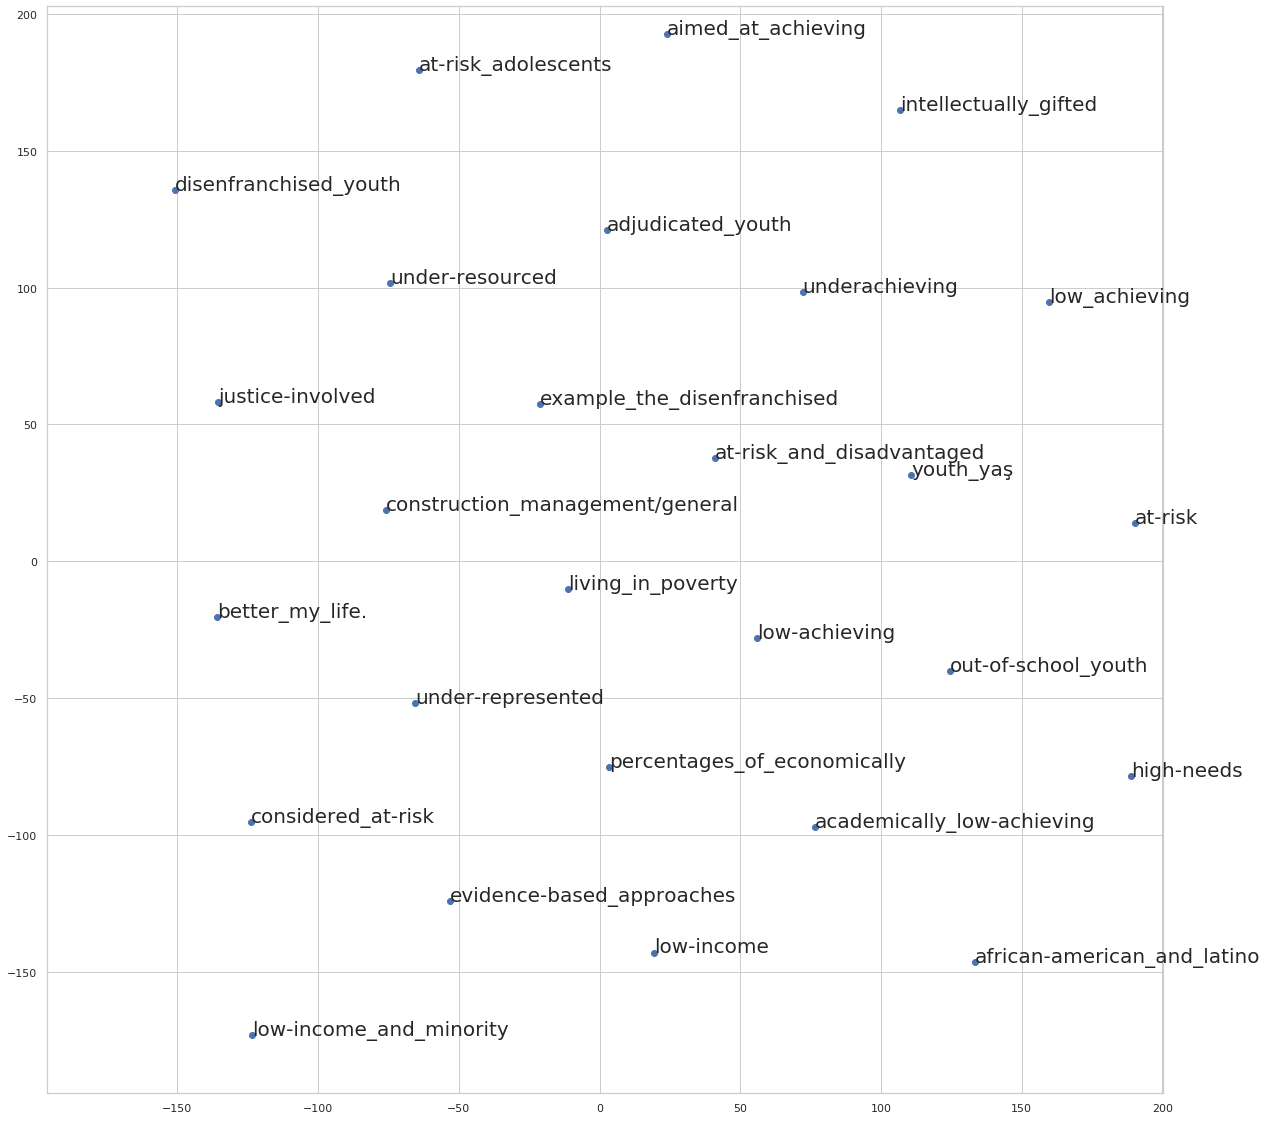

In [38]:
# Display 30 closest words to test word
display_closestwords(model, test_word, 30)

### Manually defined words

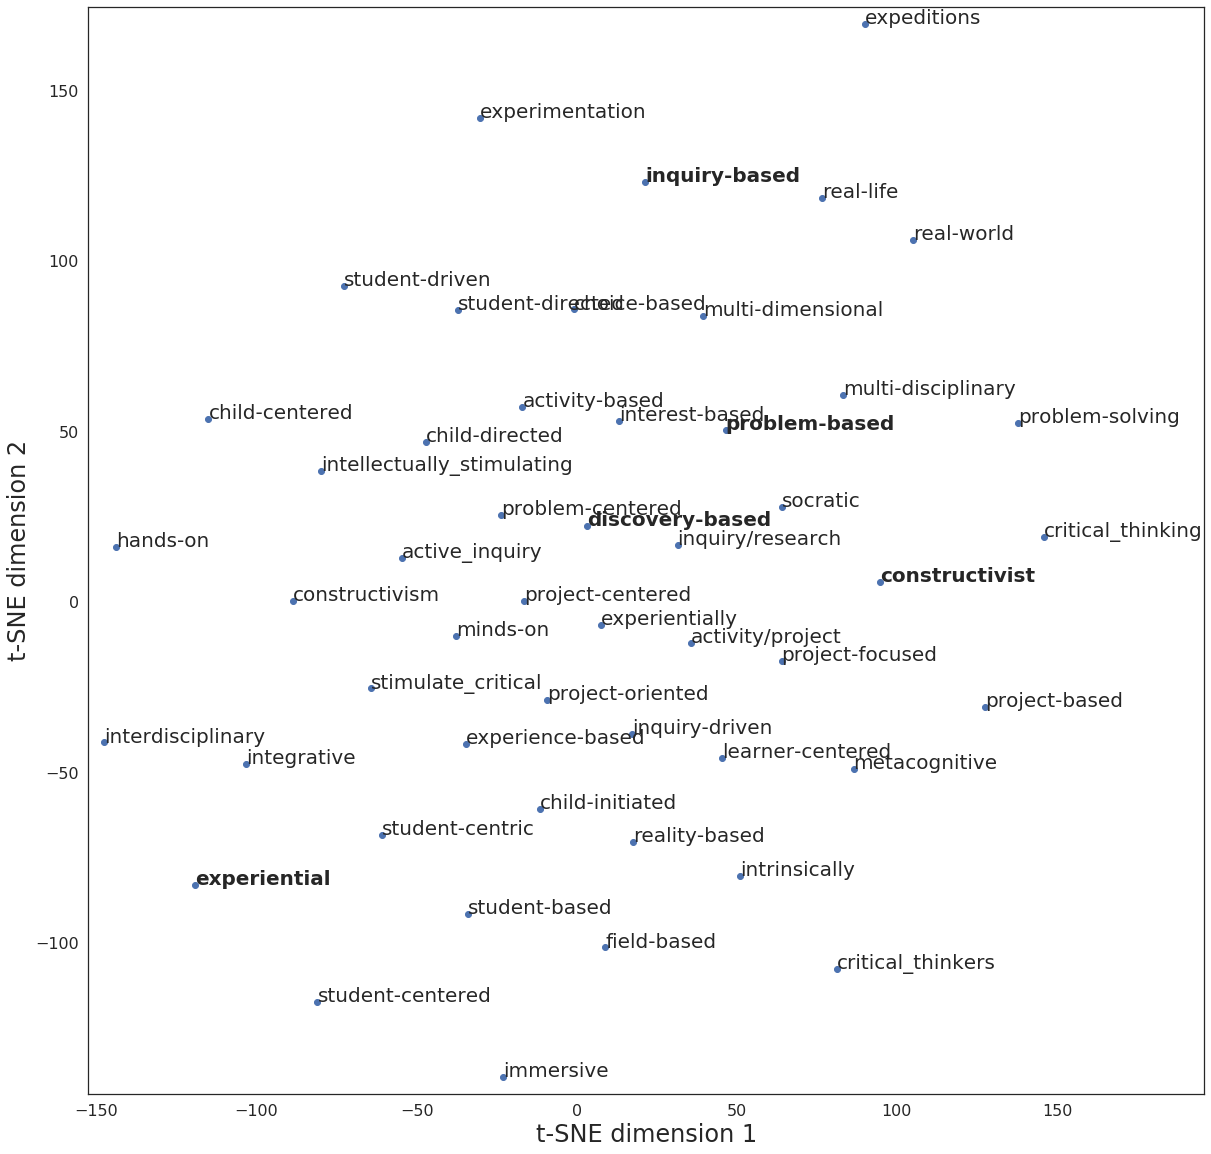

In [20]:
# TO DO: Adapt function above to be able to perform this visualization
# Set terms for visualization:
core_words = inqseed
close_words = inq50 

# Define model parameters
dimensions = 300
arr = np.empty((0,dimensions), dtype='f')
word_labels = []

# add the vector for each of the closest words to the array
for wrd_label in close_words:
    wrd_vector = model[wrd_label]
    word_labels.append(wrd_label)
    arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
# find tsne coords for 2 dimensions, using cosine distances as metric
tsne = TSNE(n_components=2, random_state=0, metric=distance.cosine)
np.set_printoptions(suppress=True)
Y = tsne.fit_transform(arr)

x_coords = Y[:, 0]
y_coords = Y[:, 1]

# display scatter plot
fig, ax = plt.subplots(figsize=(20,20))
ax.scatter(x_coords, y_coords, alpha=1, color='b')

sns.set(style='white')

for label, x, y in zip(word_labels, x_coords, y_coords):
    if label in core_words:
        ax.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontweight='bold').set_fontsize(20)
    else:
        ax.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points').set_fontsize(20)
    
ax.set_xlim(x_coords.min()-5, x_coords.max()+50)
ax.set_ylim(y_coords.min()-5, y_coords.max()+5)
ax.set_xlabel('t-SNE dimension 1')
ax.set_ylabel('t-SNE dimension 2')
ax.xaxis.label.set_fontsize(24)
ax.yaxis.label.set_fontsize(24)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)
plt.show()

In [21]:
fig.savefig("data/IBL_50_102419.png", facecolor="white", transparent=True)

## Check word frequencies and ranks

### Count frequency of candidate words

Required arguments for `count_master()` function:
- df: DataFrame with text data, each of which is a list of full-text pages (not necessarily preprocessed)
- dict_path: file path to folder containing dictionaries
- dict_names: names of dictionaries on file (list or list of lists)
- file_ext: file extension for dictionary files (probably .txt)   
- local_dicts: list of local dictionaries formatted as last of lists of terms--or if singular, just a list of terms
- local_names: names of local dictionaries (list or list of lists)

In [42]:
countsdfs = count_master(df, dict_path = dict_path, dict_names = [], file_ext = '.txt', 
                         local_dicts = [candidates_list], local_names = ["candidates"])

  2%|▏         | 9/367 [00:00<00:05, 71.26it/s]

Counting dictionaries per term for corpus...


100%|██████████| 367/367 [00:00<00:00, 167298.07it/s]

Multiprocessing complete. Collecting counts per term per dictionary...
Finished. Returning results.
TERM COUNTS FOR CANDIDATES DICTIONARY:

                               TERM  FREQUENCY
29                       low­income       4608
14                        high-risk        341
24            intellectually_gifted        202
15                       high-needs        107
25                    low_achieving        105
16                    low-achieving        105
18                  under-resourced         71
9                 under-represented         62
7                    underachieving         60
21                adjudicated_youth         40
8                  justice-involved         15
22               pregnant/parenting         13
4             disenfranchised_youth          6
27                        youth_yaş          4
20        evidence-based_approaches          0
28               aimed_at_achieving          0
26               considered_at-risk          0
2        acade

### Relative ranks of dictionary terms

Word2vec also has built-in method to compare relative ranks of terms, which go from most frequent (highest number) to least frequent. <br/> **Note** that they are NOT real counts/frequencies (see above for that).

In [ ]:
# Create Counter object: a set containing doubles, where each double is ('term': rank)
counts = Counter({word: vocab.count for (word, vocab) in model.wv.vocab.items()})
counts

In [ ]:
# TO DO: 1. Sort entries by rank before displaying; 2. show histogram of term counts for highest 20 and lowest 20 words for each dict

print("RANK FOR SEED DICTIONARY:")
for term in sorted(inqseed):
    print(str(term) + ": " + str(counts[term]))
print()
print("RANK FOR CORE DICTIONARY:")
for term in inq30:
    print(str(term) + ": " + str(counts[term]))
print()
print("RANK FOR FULL DICTIONARY:")
for term in inquiry_fin:
    print(str(term) + ": " + str(counts[term]))

In [ ]:
# 50 most frequent words (according to word2vec tracker):
model.wv.index2entity[:50]

## Validate dictionaries: Check coherence of terms across sizes

In [25]:
for dictionary in [inqseed, inq20, inq50new, inquiry_fin]:
    print(str(dict_cohere(dictionary, model)))

NameError: name 'inq50new' is not defined

In [24]:
# Can also check for words that belong LEAST to a given dictionary:
maindict = inq30

i = 0 # initialize iterator
length = len(maindict) # set length for the for loop
inqtemp = []; inqtemp = maindict # initialize temp list of dict words
similar_words = [] # initialize list of dict words sorted by similarity (least similar words most recently added -> at bottom)

while i < length:
    least_similar_word = model.doesnt_match(inqtemp)
    similar_words.append(least_similar_word)
    inqtemp.remove(least_similar_word)
    i += 1 # add to iterator

print("List of words from least to most similar:")
for term in similar_words:
    print(term)
    
# Need to re-define dictionary again at this point:
inq30 = ['discovery-based', 'student-driven_exploration', 'exploration_and_experimentation', 'laboratory-based', 
         'problem-based', 'prbl', 'learn-by-doing', 
         'project-based', 'project-centered', 
         'experiential', 'experiential_approach', 'experientially',
         'inquiry-based', 'inquiry-driven', 'student-centered_inquiry-based', 'active_inquiry', 
         'constructivist', 'constructivism', 
         'hands-on', 'hand-on', 'hands-on_learning', 'hands-on_and_minds-on', 'hands-on_minds-on', 'hands-on/minds-on', 
         'socratic', 'socratic_method', 'socratic_dialogue',
         'child-centered', 'learner-centered', 'student-centered']

NameError: name 'inq30' is not defined

### Check integrity of IBL dictionaries of varying lengths

In [130]:
# Remove any terms from core dict NOT in current model (these will have to be replaced):
for word in inq30:
    if word not in list(model.vocab):
        inq30.remove(word)
        print("NOT FOUND IN CORE DICT, REMOVING:\t" + word)

count = 0
for word in inquiry_fin:
    if word not in list(model.vocab):
        inquiry_fin.remove(word)
        count += 1
        #print("NOT FOUND in FULL DICT, REMOVING:\t" + word)

# Loop twice to catch any remaining OOV terms:
for word in inquiry_fin:
    if word not in list(model.vocab):
        inquiry_fin.remove(word)
        count += 1
        
print("Removed " + str(count) + " out-of-vocabulary terms from full dictionary.")

Removed 2 out-of-vocabulary terms from full dictionary.


In [131]:
print("Length of original dict: ", len(inq30))
print("Coherence of original dict: ", str(dict_cohere(inq30, model)))

print("Length of extended dict: ", len(inquiry_fin))
print("Coherence of extended dict: ", str(dict_cohere(inquiry_fin, model)))

Length of original dict:  30
Coherence of original dict:  0.694298374917772
Length of extended dict:  498
Coherence of extended dict:  0.5983296162685932


In [132]:
# Use random adds to create a few dicts of different lengths from max length of 500:

print("TESTING DIFFERENT LENGTHS USING RANDOM ADDITIONS:\n")
# TO DO: Write function expand_dict() above to automate this

inqlist = []; inqlist = inq30 # initialize placeholder for each growing dict
print(str(len(inqlist)) + "-term dict has this much coherence:", str(dict_cohere(inq30, model)))
print()

# 40 terms:
inqlist.extend(np.random.choice([term for term in filter(lambda x: x not in inq30, inquiry_fin) if term in list(model.vocab)], size=10, replace=False))
inq40 = []; inq40 = inqlist
print(str(len(inqlist)) + "-term dict has this much coherence:", str(dict_cohere(inq40, model)))
print()

# 50 terms:
inqlist.extend(np.random.choice([term for term in filter(lambda x: x not in inq40, inquiry_fin) if term in list(model.vocab)], size=10, replace=False))
inq50 = inqlist
#print("50 terms: \n", [term for term in inq50])
print(str(len(inqlist)) + "-term dict has this much coherence:", str(dict_cohere(inq50, model)))
print()

# 75 terms:
inqlist.extend(np.random.choice([term for term in filter(lambda x: x not in inq50, inquiry_fin) if term in list(model.vocab)], size=25, replace=False))
inq75 = inqlist
#print("75 terms: \n", [term for term in inq75])
print(str(len(inqlist)) + "-term dict has this much coherence:", str(dict_cohere(inq75, model)))
print()

# 100 terms:
inqlist.extend(np.random.choice([term for term in filter(lambda x: x not in inq75, inquiry_fin) if term in list(model.vocab)], size=25, replace=False))
inq100 = inqlist
#print("100 terms: \n", [term for term in inq100])
print(str(len(inqlist)) + "-term dict has this much coherence:", str(dict_cohere(inq100, model)))
print()

# 200 terms:
inqlist.extend(np.random.choice([term for term in filter(lambda x: x not in inq100, inquiry_fin) if term in list(model.vocab)], size=100, replace=False))
inq200 = inqlist
#print("200 terms: \n", [term for term in inq200])
print(str(len(inqlist)) + "-term dict has this much coherence:", str(dict_cohere(inq200, model)))
print()

# 300 terms:
inqlist.extend(np.random.choice([term for term in filter(lambda x: x not in inq200, inquiry_fin) if term in list(model.vocab)], size=100, replace=False))
inq300 = inqlist
print(str(len(inqlist)) + "-term dict has this much coherence:", str(dict_cohere(inq300, model)))
print()

# 400 terms:
inqlist.extend(np.random.choice([term for term in filter(lambda x: x not in inq300, inquiry_fin) if term in list(model.vocab)], size=100, replace=False))
inq400 = inqlist
print(str(len(inqlist)) + "-term dict has this much coherence:", str(dict_cohere(inq400, model)))
print()

print("500-term dict has this much coherence:", str(dict_cohere(inquiry_fin, model)))

TESTING DIFFERENT LENGTHS USING RANDOM ADDITIONS:

30-term dict has this much coherence: 0.694298374917772

40-term dict has this much coherence: 0.6336066746711732

50-term dict has this much coherence: 0.6267515384674072

75-term dict has this much coherence: 0.6087374311659071

100-term dict has this much coherence: 0.6085788740158081

200-term dict has this much coherence: 0.6090105971336366

300-term dict has this much coherence: 0.6010488780551487

400-term dict has this much coherence: 0.6033310662269595

500-term dict has this much coherence: 0.5983296162685932


In [133]:
# TO DO: Fix this

# Use removal of least similar word vectors to create a few dicts of different lengths from max length of 500:
lens_list = [500, 400, 300, 200, 100, 75, 60, 50, 40, 30] # Define desired dict lengths

# Load full 500-term dicts:
inquiry_fin = [elem.strip('\n') for elem in load_list('data/inquiry500.txt')]

# Remove any terms from core dict NOT in current model (these will have to be replaced):
for word in inq30:
    if word not in list(model.vocab):
        inq30.remove(word)
        print("NOT FOUND IN CORE DICT, REMOVING:\t" + word)
print()

count = 0
for word in inquiry_fin:
    if word not in list(model.vocab):
        inquiry_fin.remove(word)
        count += 1
        #print("NOT FOUND in FULL DICT, REMOVING:\t" + word)
        
for word in inquiry_fin:
    if word not in list(model.vocab):
        inquiry_fin.remove(word)
        count += 1
    
print("Removed " + str(count) + " out-of-vocabulary terms from full dictionary.")

print('TESTING DICT LENGTHS BY REMOVING LEAST SIMILAR WORD VECTORS:\n')

for dictlen in lens_list: 
    inqdict = [],
    
    inqdict = focus_dict(inquiry_fin, inq30, dictlen, model)
    
    print(str(dictlen) + "-term dicts have this much coherence:", str(dict_cohere(inqdict, model)))
    print()


Removed 2 out-of-vocabulary terms from full dictionary.
TESTING DICT LENGTHS BY REMOVING LEAST SIMILAR WORD VECTORS:

500-term dicts have this much coherence: 0.5983296162685932



/opt/conda/lib/python3.6/site-packages/gensim/models/keyedvectors.py:876: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


400-term dicts have this much coherence: 0.6033310662269596



ValueError: cannot select a word from an empty list

## Surprising trends in analyzing how dictionary length affects inter-dictionary opposition and within-dictionary coherence (from this and other analyses):
### Greater lengths make for more within-dictionary coherence, but less across-dictionary opposition.
### Trimming word vectors randomly yields dictionaries that are less coherent and more opposing than does trimming those word vectors least similar to the others in the dictionary.
#### Caveat: The above patterns assume (perhaps consequentially, perhaps not) that as we trim dictionaries, we are keeping a small, core list of concepts (here, 30) intact within each dictionary. The size of this core may influence the above dynamics, as may the relative size of the total dictionary compared to the core list.